# Assignment 1: Object Detection for Wildlife Conservation
## Detecting Waterfowl in UAV Thermal Imagery

**Approach:** YOLOv8 (You Only Look Once v8) - object detection model

**Dataset:** UAV-derived Waterfowl Thermal Imagery Dataset
- Primary: Thermal imagery (grayscale TIFF images)
- Task: Detect and localize waterfowl with bounding boxes

**Pipeline Overview:**
1. Data preparation and preprocessing
2. Dataset split (train/val/test)
3. Data augmentation
4. Model training with YOLOv8
5. Evaluation with metrics (mAP, Precision, Recall)
6. Visualization and error analysis

## 1. Setup and Import Libraries

In [16]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2
from pathlib import Path
import shutil
from sklearn.model_selection import train_test_split
from PIL import Image
import yaml
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

# Set paths
PROJECT_ROOT = Path(r"c:\Users\2004l\Desktop\CV-assignment")
DATA_ROOT = PROJECT_ROOT / "data" / "00_UAV-derived Thermal Waterfowl Dataset"
IMAGES_DIR = DATA_ROOT / "01_Posistive Image"
LABELS_CSV = DATA_ROOT / "02_Groundtruth Label for Positive Images" / "Bounding Box Label.csv"
NEGATIVE_IMAGES_DIR = DATA_ROOT / "03_Negative Images"

# Output directories
OUTPUT_DIR = PROJECT_ROOT / "yolo_dataset"
RESULTS_DIR = PROJECT_ROOT / "results"

print(f"Project root: {PROJECT_ROOT}")
print(f"Images directory exists: {IMAGES_DIR.exists()}")
print(f"Labels CSV exists: {LABELS_CSV.exists()}")
print(f"Number of positive images: {len(list(IMAGES_DIR.glob('*.tif')))}")

Project root: c:\Users\2004l\Desktop\CV-assignment
Images directory exists: True
Labels CSV exists: True
Number of positive images: 355


## 2. Data Exploration and Analysis

Dataset Overview:
Total annotations: 8975
Unique images with waterfowl: 355

First few annotations:
               imageFilename  x(column)  y(row)  width  height
0  20180322_101536_979_R.tif        127      11      7       7
1  20180322_101536_979_R.tif        174      32      7       7
2  20180322_101536_979_R.tif        178      19      7       7
3  20180322_101536_979_R.tif        199      31      7       7
4  20180322_101536_979_R.tif        223      51      7       7
5  20180322_101536_979_R.tif        228      48      7       7
6  20180322_101536_979_R.tif        236      42      7       7
7  20180322_101536_979_R.tif        291      46      7       7
8  20180322_101536_979_R.tif        310      16      7       7
9  20180322_101536_979_R.tif        301      42      7       7

Annotations per image statistics:
Mean: 25.28
Median: 17.00
Min: 1
Max: 157


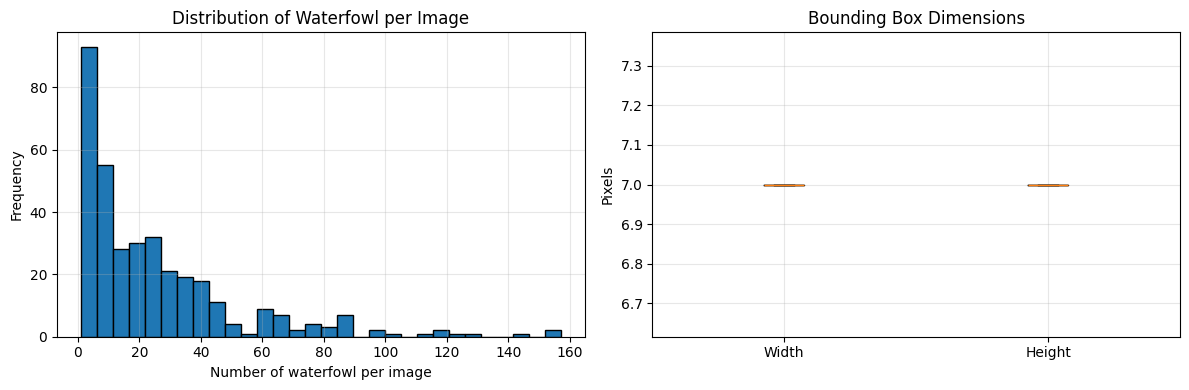

In [17]:
# Load and explore the annotations
df_labels = pd.read_csv(LABELS_CSV)
print("Dataset Overview:")
print(f"Total annotations: {len(df_labels)}")
print(f"Unique images with waterfowl: {df_labels['imageFilename'].nunique()}")
print(f"\nFirst few annotations:")
print(df_labels.head(10))

# Statistics
print(f"\nAnnotations per image statistics:")
annotations_per_image = df_labels.groupby('imageFilename').size()
print(f"Mean: {annotations_per_image.mean():.2f}")
print(f"Median: {annotations_per_image.median():.2f}")
print(f"Min: {annotations_per_image.min()}")
print(f"Max: {annotations_per_image.max()}")

# Visualize distribution
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.hist(annotations_per_image, bins=30, edgecolor='black')
plt.xlabel('Number of waterfowl per image')
plt.ylabel('Frequency')
plt.title('Distribution of Waterfowl per Image')
plt.grid(alpha=0.3)

plt.subplot(1, 2, 2)
plt.boxplot([df_labels['width'], df_labels['height']], labels=['Width', 'Height'])
plt.ylabel('Pixels')
plt.title('Bounding Box Dimensions')
plt.grid(alpha=0.3)

plt.tight_layout()
plt.show()

Sample image: 20180322_101536_979_R.tif
Image shape: (512, 640)
Image dtype: uint8
Value range: [0, 255]

Image shape: (512, 640)
Image dtype: uint8
Value range: [0, 255]


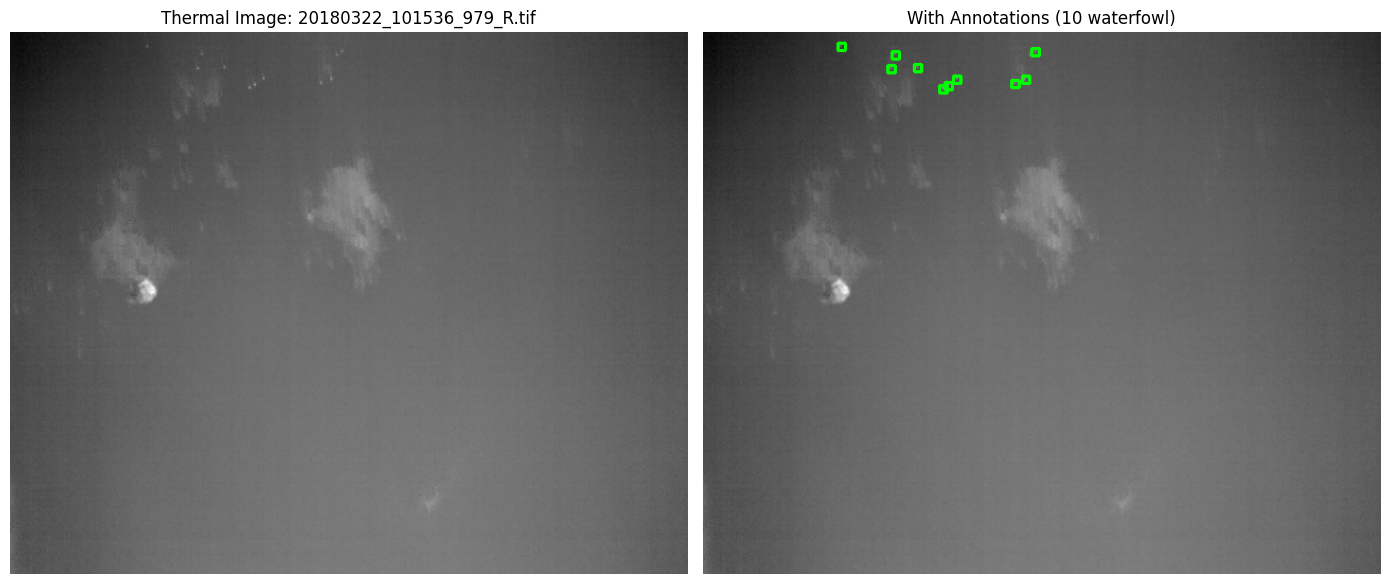

In [18]:
# Load and visualize sample thermal image
sample_image_name = df_labels['imageFilename'].iloc[0]
sample_image_path = IMAGES_DIR / sample_image_name
sample_img = Image.open(sample_image_path)
sample_array = np.array(sample_img)

print(f"Sample image: {sample_image_name}")
print(f"Image shape: {sample_array.shape}")
print(f"Image dtype: {sample_array.dtype}")
print(f"Value range: [{sample_array.min()}, {sample_array.max()}]")

# Get annotations for this image
sample_annotations = df_labels[df_labels['imageFilename'] == sample_image_name]

# Visualize
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Original thermal image
axes[0].imshow(sample_array, cmap='gray')
axes[0].set_title(f'Thermal Image: {sample_image_name}')
axes[0].axis('off')

# Image with bounding boxes
img_with_boxes = sample_array.copy()
if len(img_with_boxes.shape) == 2:
    img_with_boxes = cv2.cvtColor(img_with_boxes.astype(np.uint8), cv2.COLOR_GRAY2RGB)
else:
    img_with_boxes = img_with_boxes.astype(np.uint8)

for _, row in sample_annotations.iterrows():
    x, y, w, h = int(row['x(column)']), int(row['y(row)']), int(row['width']), int(row['height'])
    cv2.rectangle(img_with_boxes, (x, y), (x+w, y+h), (0, 255, 0), 2)

axes[1].imshow(img_with_boxes)
axes[1].set_title(f'With Annotations ({len(sample_annotations)} waterfowl)')
axes[1].axis('off')

plt.tight_layout()
plt.show()

## 3. Data Preparation for YOLO Format

YOLO requires:
- Images in JPG/PNG format
- Label files in TXT format (one per image)
- Format: `class_id x_center y_center width height` (normalized 0-1)
- Dataset structure: `images/train`, `images/val`, `images/test` and corresponding `labels/` folders

In [19]:
def convert_bbox_to_yolo(x, y, w, h, img_width, img_height):
    """
    Convert bounding box from (x, y, width, height) to YOLO format.
    YOLO format: (x_center, y_center, width, height) normalized to [0, 1]
    """
    x_center = (x + w / 2) / img_width
    y_center = (y + h / 2) / img_height
    width = w / img_width
    height = h / img_height
    return x_center, y_center, width, height

def prepare_yolo_dataset(df, images_dir, output_dir, split_ratios=(0.7, 0.15, 0.15)):
    """
    Prepare dataset in YOLO format with train/val/test splits.
    
    Args:
        df: DataFrame with annotations
        images_dir: Path to images directory
        output_dir: Path to output directory
        split_ratios: Tuple of (train, val, test) ratios
    """
    # Create directory structure
    for split in ['train', 'val', 'test']:
        (output_dir / 'images' / split).mkdir(parents=True, exist_ok=True)
        (output_dir / 'labels' / split).mkdir(parents=True, exist_ok=True)
    
    # Get unique image filenames
    unique_images = df['imageFilename'].unique()
    print(f"Total unique images: {len(unique_images)}")
    
    # Split dataset
    train_ratio, val_ratio, test_ratio = split_ratios
    train_imgs, temp_imgs = train_test_split(unique_images, test_size=(1-train_ratio), random_state=42)
    val_imgs, test_imgs = train_test_split(temp_imgs, test_size=test_ratio/(val_ratio+test_ratio), random_state=42)
    
    print(f"Train images: {len(train_imgs)}")
    print(f"Val images: {len(val_imgs)}")
    print(f"Test images: {len(test_imgs)}")
    
    splits = {
        'train': train_imgs,
        'val': val_imgs,
        'test': test_imgs
    }
    
    # Process each split
    for split_name, img_list in splits.items():
        print(f"\nProcessing {split_name} split...")
        
        for img_name in tqdm(img_list):
            # Read image
            img_path = images_dir / img_name
            if not img_path.exists():
                print(f"Warning: Image not found: {img_path}")
                continue
                
            img = Image.open(img_path)
            img_array = np.array(img)
            
            # Convert to RGB if grayscale
            if len(img_array.shape) == 2:
                img_array = np.stack([img_array] * 3, axis=-1)
            
            img_height, img_width = img_array.shape[:2]
            
            # Save image as PNG
            output_img_path = output_dir / 'images' / split_name / f"{img_name.replace('.tif', '.png')}"
            Image.fromarray(img_array).save(output_img_path)
            
            # Get annotations for this image
            img_annotations = df[df['imageFilename'] == img_name]
            
            # Create YOLO format label file
            label_path = output_dir / 'labels' / split_name / f"{img_name.replace('.tif', '.txt')}"
            with open(label_path, 'w') as f:
                for _, row in img_annotations.iterrows():
                    x, y, w, h = row['x(column)'], row['y(row)'], row['width'], row['height']
                    x_center, y_center, width, height = convert_bbox_to_yolo(x, y, w, h, img_width, img_height)
                    # Class 0 for waterfowl
                    f.write(f"0 {x_center:.6f} {y_center:.6f} {width:.6f} {height:.6f}\n")
    
    return splits

# Prepare the dataset
print("Preparing YOLO dataset...")
splits = prepare_yolo_dataset(df_labels, IMAGES_DIR, OUTPUT_DIR)
print("\nDataset preparation complete!")

Preparing YOLO dataset...
Total unique images: 355
Train images: 248
Val images: 53
Test images: 54

Processing train split...


100%|██████████| 248/248 [00:10<00:00, 24.53it/s]



Processing val split...


100%|██████████| 53/53 [00:01<00:00, 26.74it/s]



Processing test split...


100%|██████████| 54/54 [00:02<00:00, 19.86it/s]


Dataset preparation complete!


In [20]:
# Create YOLO configuration file
yaml_config = {
    'path': str(OUTPUT_DIR.absolute()),
    'train': 'images/train',
    'val': 'images/val',
    'test': 'images/test',
    'names': {
        0: 'waterfowl'
    },
    'nc': 1  # number of classes
}

config_path = OUTPUT_DIR / 'data.yaml'
with open(config_path, 'w') as f:
    yaml.dump(yaml_config, f, default_flow_style=False)

print(f"YOLO config saved to: {config_path}")
print("\nConfig contents:")
with open(config_path, 'r') as f:
    print(f.read())

YOLO config saved to: c:\Users\2004l\Desktop\CV-assignment\yolo_dataset\data.yaml

Config contents:
names:
  0: waterfowl
nc: 1
path: c:\Users\2004l\Desktop\CV-assignment\yolo_dataset
test: images/test
train: images/train
val: images/val



## 4. Model Training with YOLOv8

**Training Configuration:**
- Model: YOLOv8n (nano) - fast and efficient for initial training
- Can upgrade to YOLOv8s/m/l for better accuracy
- Optimizer: AdamW with cosine learning rate schedule

In [21]:
from ultralytics import YOLO

# Initialize YOLOv8 model
# Options: yolov8n.pt (nano), yolov8s.pt (small), yolov8m.pt (medium), yolov8l.pt (large)
model = YOLO('yolov8n.pt')  # Start with nano for faster training

print("Model initialized successfully!")
print(f"Model architecture: YOLOv8n")

Model initialized successfully!
Model architecture: YOLOv8n


In [22]:
# Train the model
# Training hyperparameters following best practices
results = model.train(
    data=str(config_path),
    epochs=100,  # Full training epochs
    imgsz=640,  # Image size (640x640)
    batch=16,  # Batch size (adjust based on GPU memory)
    patience=20,  # Early stopping patience
    save=True,  # Save best and last checkpoints
    device='cuda',  # Use GPU (will auto-fallback to CPU if not available)
    workers=4,  # Number of dataloader workers
    project=str(RESULTS_DIR),
    name='waterfowl_detection',
    exist_ok=True,
    
    # Data augmentation (built-in)
    hsv_h=0.015,  # Image HSV-Hue augmentation
    hsv_s=0.7,  # Image HSV-Saturation augmentation
    hsv_v=0.4,  # Image HSV-Value augmentation
    degrees=10.0,  # Image rotation (+/- deg)
    translate=0.1,  # Image translation (+/- fraction)
    scale=0.5,  # Image scale (+/- gain)
    shear=0.0,  # Image shear (+/- deg)
    perspective=0.0,  # Image perspective (+/- fraction)
    flipud=0.0,  # Image flip up-down (probability)
    fliplr=0.5,  # Image flip left-right (probability)
    mosaic=1.0,  # Mosaic augmentation (probability)
    mixup=0.0,  # MixUp augmentation (probability)
    
    # Optimizer
    optimizer='AdamW',  # Optimizer (SGD, Adam, AdamW)
    lr0=0.01,  # Initial learning rate
    lrf=0.01,  # Final learning rate (lr0 * lrf)
    momentum=0.937,  # SGD momentum/Adam beta1
    weight_decay=0.0005,  # Optimizer weight decay
    warmup_epochs=3.0,  # Warmup epochs
    warmup_momentum=0.8,  # Warmup initial momentum
    
    # Loss
    box=7.5,  # Box loss gain
    cls=0.5,  # Class loss gain
    dfl=1.5,  # DFL loss gain
    
    # Validation
    val=True,  # Validate during training
    plots=True,  # Save plots during training
    save_period=-1,  # Save checkpoint every x epochs (-1 = disabled)
)

print("\nTraining complete!")
print(f"Best model saved at: {RESULTS_DIR / 'waterfowl_detection' / 'weights' / 'best.pt'}")

New https://pypi.org/project/ultralytics/8.3.228 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.227  Python-3.13.5 torch-2.9.0+cu128 CUDA:0 (NVIDIA GeForce RTX 3060 Laptop GPU, 6144MiB)
Ultralytics 8.3.227  Python-3.13.5 torch-2.9.0+cu128 CUDA:0 (NVIDIA GeForce RTX 3060 Laptop GPU, 6144MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=c:\Users\2004l\Desktop\CV-assignment\yolo_dataset\data.yaml, degrees=10.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=100, erasing=0.4, exist_ok=True, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01,

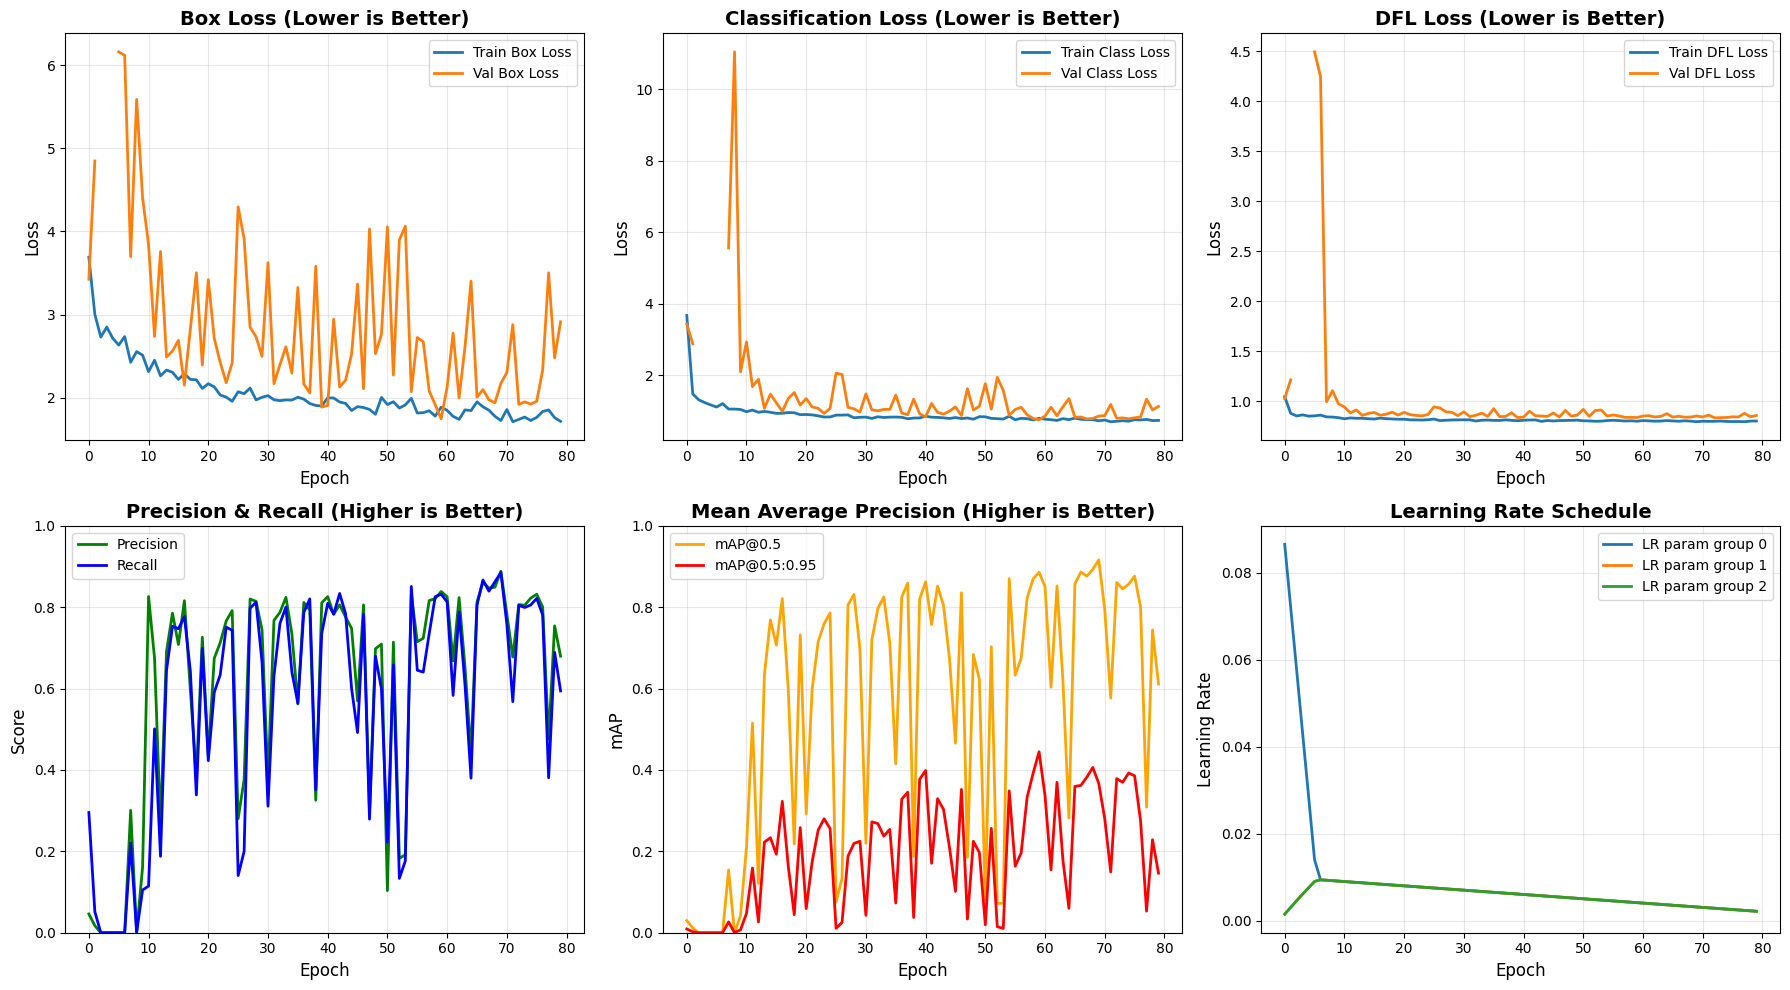


TRAINING SUMMARY

Final Epoch (80):
  • Precision: 0.6797 (of predicted boxes, how many are correct)
  • Recall: 0.5943 (of all ground truth, how many detected)
  • mAP@0.5: 0.6113 (standard metric)
  • mAP@0.5:0.95: 0.1463 (strict metric)

Best Epoch:
  • Precision: 0.8885
  • Recall: 0.8852
  • mAP@0.5: 0.9163
  • mAP@0.5:0.95: 0.3665

INTERPRETATION GUIDE
• Precision: High = Few false alarms (false positives)
• Recall: High = Few missed birds (false negatives)
• mAP@0.5: Standard metric (IoU threshold 0.5)
• mAP@0.5:0.95: Strict metric (average over multiple IoU thresholds)


In [23]:
# Visualize training curves
results_path = RESULTS_DIR / 'waterfowl_detection'

# Load and display training results
try:
    results_csv = pd.read_csv(results_path / 'results.csv')
    results_csv.columns = results_csv.columns.str.strip()
    
    fig, axes = plt.subplots(2, 3, figsize=(18, 10))
    
    # Loss curves
    axes[0, 0].plot(results_csv['train/box_loss'], label='Train Box Loss', linewidth=2)
    axes[0, 0].plot(results_csv['val/box_loss'], label='Val Box Loss', linewidth=2)
    axes[0, 0].set_xlabel('Epoch', fontsize=12)
    axes[0, 0].set_ylabel('Loss', fontsize=12)
    axes[0, 0].set_title('Box Loss (Lower is Better)', fontsize=14, fontweight='bold')
    axes[0, 0].legend()
    axes[0, 0].grid(alpha=0.3)
    
    axes[0, 1].plot(results_csv['train/cls_loss'], label='Train Class Loss', linewidth=2)
    axes[0, 1].plot(results_csv['val/cls_loss'], label='Val Class Loss', linewidth=2)
    axes[0, 1].set_xlabel('Epoch', fontsize=12)
    axes[0, 1].set_ylabel('Loss', fontsize=12)
    axes[0, 1].set_title('Classification Loss (Lower is Better)', fontsize=14, fontweight='bold')
    axes[0, 1].legend()
    axes[0, 1].grid(alpha=0.3)
    
    axes[0, 2].plot(results_csv['train/dfl_loss'], label='Train DFL Loss', linewidth=2)
    axes[0, 2].plot(results_csv['val/dfl_loss'], label='Val DFL Loss', linewidth=2)
    axes[0, 2].set_xlabel('Epoch', fontsize=12)
    axes[0, 2].set_ylabel('Loss', fontsize=12)
    axes[0, 2].set_title('DFL Loss (Lower is Better)', fontsize=14, fontweight='bold')
    axes[0, 2].legend()
    axes[0, 2].grid(alpha=0.3)
    
    # Metrics curves
    axes[1, 0].plot(results_csv['metrics/precision(B)'], label='Precision', linewidth=2, color='green')
    axes[1, 0].plot(results_csv['metrics/recall(B)'], label='Recall', linewidth=2, color='blue')
    axes[1, 0].set_xlabel('Epoch', fontsize=12)
    axes[1, 0].set_ylabel('Score', fontsize=12)
    axes[1, 0].set_title('Precision & Recall (Higher is Better)', fontsize=14, fontweight='bold')
    axes[1, 0].set_ylim([0, 1])
    axes[1, 0].legend()
    axes[1, 0].grid(alpha=0.3)
    
    axes[1, 1].plot(results_csv['metrics/mAP50(B)'], label='mAP@0.5', linewidth=2, color='orange')
    axes[1, 1].plot(results_csv['metrics/mAP50-95(B)'], label='mAP@0.5:0.95', linewidth=2, color='red')
    axes[1, 1].set_xlabel('Epoch', fontsize=12)
    axes[1, 1].set_ylabel('mAP', fontsize=12)
    axes[1, 1].set_title('Mean Average Precision (Higher is Better)', fontsize=14, fontweight='bold')
    axes[1, 1].set_ylim([0, 1])
    axes[1, 1].legend()
    axes[1, 1].grid(alpha=0.3)
    
    # Learning rate
    axes[1, 2].plot(results_csv['lr/pg0'], label='LR param group 0', linewidth=2)
    axes[1, 2].plot(results_csv['lr/pg1'], label='LR param group 1', linewidth=2)
    axes[1, 2].plot(results_csv['lr/pg2'], label='LR param group 2', linewidth=2)
    axes[1, 2].set_xlabel('Epoch', fontsize=12)
    axes[1, 2].set_ylabel('Learning Rate', fontsize=12)
    axes[1, 2].set_title('Learning Rate Schedule', fontsize=14, fontweight='bold')
    axes[1, 2].legend()
    axes[1, 2].grid(alpha=0.3)
    
    plt.tight_layout()
    plt.savefig(RESULTS_DIR / 'training_curves.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # Print final metrics
    print("\n" + "="*80)
    print("TRAINING SUMMARY")
    print("="*80)
    final_epoch = results_csv.iloc[-1]
    print(f"\nFinal Epoch ({int(final_epoch['epoch'])}):")
    print(f"  • Precision: {final_epoch['metrics/precision(B)']:.4f} (of predicted boxes, how many are correct)")
    print(f"  • Recall: {final_epoch['metrics/recall(B)']:.4f} (of all ground truth, how many detected)")
    print(f"  • mAP@0.5: {final_epoch['metrics/mAP50(B)']:.4f} (standard metric)")
    print(f"  • mAP@0.5:0.95: {final_epoch['metrics/mAP50-95(B)']:.4f} (strict metric)")
    
    # Find best epoch
    best_epoch_idx = results_csv['metrics/mAP50(B)'].idxmax()
    best_epoch = results_csv.iloc[best_epoch_idx]
    print(f"\nBest Epoch:")
    print(f"  • Precision: {best_epoch['metrics/precision(B)']:.4f}")
    print(f"  • Recall: {best_epoch['metrics/recall(B)']:.4f}")
    print(f"  • mAP@0.5: {best_epoch['metrics/mAP50(B)']:.4f}")
    print(f"  • mAP@0.5:0.95: {best_epoch['metrics/mAP50-95(B)']:.4f}")
    
    print("\n" + "="*80)
    print("INTERPRETATION GUIDE")
    print("="*80)
    print("• Precision: High = Few false alarms (false positives)")
    print("• Recall: High = Few missed birds (false negatives)")
    print("• mAP@0.5: Standard metric (IoU threshold 0.5)")
    print("• mAP@0.5:0.95: Strict metric (average over multiple IoU thresholds)")
    print("="*80)
    
except Exception as e:
    print(f"Could not load results.csv: {e}")
    print("Results will be available after training completes.")

## 5. Model Evaluation on Test Set

**Evaluation Metrics:**
- **mAP (mean Average Precision)**: Overall detection performance
  - mAP@0.5: IoU threshold of 0.5 (standard)
  - mAP@0.5:0.95: Average over IoU thresholds 0.5 to 0.95 (more strict)
- **Precision**: Of all predicted detections, how many are correct?
- **Recall**: Of all ground truth objects, how many did we detect?
- **F1-Score**: Harmonic mean of precision and recall

In [24]:
# Load best trained model
best_model_path = RESULTS_DIR / 'waterfowl_detection' / 'weights' / 'best.pt'
model_best = YOLO(str(best_model_path))

# Validate on test set
test_results = model_best.val(
    data=str(config_path),
    split='test',
    imgsz=640,
    batch=16,
    conf=0.25,  # Confidence threshold
    iou=0.6,  # NMS IoU threshold
    device='cuda',
    plots=True,
    save_json=True,
)

print("\n" + "="*80)
print("TEST SET EVALUATION RESULTS")
print("="*80)
print(f"\nmAP@0.5: {test_results.box.map50:.4f} ({test_results.box.map50*100:.2f}%)")
print(f"mAP@0.5:0.95: {test_results.box.map:.4f} ({test_results.box.map*100:.2f}%)")
print(f"Precision: {test_results.box.mp:.4f} ({test_results.box.mp*100:.2f}%)")
print(f"Recall: {test_results.box.mr:.4f} ({test_results.box.mr*100:.2f}%)")

# Calculate F1-score
if test_results.box.mp > 0 and test_results.box.mr > 0:
    f1_score = 2 * (test_results.box.mp * test_results.box.mr) / (test_results.box.mp + test_results.box.mr)
    print(f"F1-Score: {f1_score:.4f} ({f1_score*100:.2f}%)")

print("\n" + "="*80)
print("WHAT DO THESE NUMBERS MEAN?")
print("="*80)
print(f"• Out of every 100 detected birds, {int(test_results.box.mp*100)} are correct (Precision)")
print(f"• Out of every 100 actual birds, we detected {int(test_results.box.mr*100)} of them (Recall)")
print(f"• Overall detection quality: {test_results.box.map50*100:.1f}% (mAP@0.5)")
print("="*80)

Ultralytics 8.3.227  Python-3.13.5 torch-2.9.0+cu128 CUDA:0 (NVIDIA GeForce RTX 3060 Laptop GPU, 6144MiB)
Model summary (fused): 72 layers, 3,005,843 parameters, 0 gradients, 8.1 GFLOPs
Model summary (fused): 72 layers, 3,005,843 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access  (ping: 0.00.0 ms, read: 30.52.2 MB/s, size: 241.4 KB)
val: Scanning C:\Users\2004l\Desktop\CV-assignment\yolo_dataset\labels\test.cache... 54 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 54/54 158.5Kit/s 0.0s
val: Fast image access  (ping: 0.00.0 ms, read: 30.52.2 MB/s, size: 241.4 KB)
val: Scanning C:\Users\2004l\Desktop\CV-assignment\yolo_dataset\labels\test.cache... 54 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 54/54 158.5Kit/s 0.0s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 4/4 0.7it/s 5.6s1.1ss
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 4/4 0.7it/s 5.6s

## 6. Visualization and Error Analysis

We'll analyze three types of predictions:
1. **True Positives (TP)**: Correct detections - model found waterfowl correctly
2. **False Negatives (FN)**: Missed detections - waterfowl present but not detected
3. **False Positives (FP)**: Incorrect detections - model detected something that isn't waterfowl

In [25]:
def calculate_iou(box1, box2):
    """
    Calculate IoU between two boxes.
    Boxes format: (x1, y1, x2, y2)
    """
    x1_1, y1_1, x2_1, y2_1 = box1
    x1_2, y1_2, x2_2, y2_2 = box2
    
    # Calculate intersection
    x1_i = max(x1_1, x1_2)
    y1_i = max(y1_1, y1_2)
    x2_i = min(x2_1, x2_2)
    y2_i = min(y2_1, y2_2)
    
    if x2_i < x1_i or y2_i < y1_i:
        return 0.0
    
    intersection = (x2_i - x1_i) * (y2_i - y1_i)
    
    # Calculate union
    area1 = (x2_1 - x1_1) * (y2_1 - y1_1)
    area2 = (x2_2 - x1_2) * (y2_2 - y1_2)
    union = area1 + area2 - intersection
    
    return intersection / union if union > 0 else 0

def analyze_predictions(model, image_path, label_path, conf_threshold=0.25, iou_threshold=0.5):
    """
    Analyze predictions and categorize as TP, FP, FN.
    """
    # Load image
    img = cv2.imread(str(image_path))
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    h, w = img.shape[:2]
    
    # Get predictions
    results = model.predict(image_path, conf=conf_threshold, verbose=False)[0]
    predictions = []
    if results.boxes is not None and len(results.boxes) > 0:
        for box in results.boxes:
            x1, y1, x2, y2 = box.xyxy[0].cpu().numpy()
            conf = box.conf[0].cpu().numpy()
            predictions.append({
                'box': (x1, y1, x2, y2),
                'conf': conf
            })
    
    # Load ground truth
    ground_truths = []
    if label_path.exists():
        with open(label_path, 'r') as f:
            for line in f:
                parts = line.strip().split()
                if len(parts) >= 5:
                    cls, x_center, y_center, width, height = map(float, parts[:5])
                    # Convert from YOLO format to xyxy
                    x1 = (x_center - width / 2) * w
                    y1 = (y_center - height / 2) * h
                    x2 = (x_center + width / 2) * w
                    y2 = (y_center + height / 2) * h
                    ground_truths.append((x1, y1, x2, y2))
    
    # Match predictions to ground truths
    matched_gt = set()
    true_positives = []
    false_positives = []
    
    for pred in predictions:
        pred_box = pred['box']
        best_iou = 0
        best_gt_idx = -1
        
        for gt_idx, gt_box in enumerate(ground_truths):
            if gt_idx in matched_gt:
                continue
            iou = calculate_iou(pred_box, gt_box)
            if iou > best_iou:
                best_iou = iou
                best_gt_idx = gt_idx
        
        if best_iou >= iou_threshold:
            true_positives.append(pred)
            matched_gt.add(best_gt_idx)
        else:
            false_positives.append(pred)
    
    # Unmatched ground truths are false negatives
    false_negatives = [ground_truths[i] for i in range(len(ground_truths)) if i not in matched_gt]
    
    return {
        'image': img_rgb,
        'true_positives': true_positives,
        'false_positives': false_positives,
        'false_negatives': false_negatives,
        'ground_truths': ground_truths,
        'predictions': predictions
    }

def visualize_detection_analysis(analysis, title):
    """
    Visualize detection analysis with color-coded boxes.
    """
    img = analysis['image'].copy()
    
    # Draw ground truth boxes (in blue)
    for gt_box in analysis['ground_truths']:
        x1, y1, x2, y2 = map(int, gt_box)
        cv2.rectangle(img, (x1, y1), (x2, y2), (0, 0, 255), 2)
    
    # Draw true positives (in green)
    for tp in analysis['true_positives']:
        x1, y1, x2, y2 = map(int, tp['box'])
        cv2.rectangle(img, (x1, y1), (x2, y2), (0, 255, 0), 2)
        cv2.putText(img, f"{tp['conf']:.2f}", (x1, y1-5), 
                   cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)
    
    # Draw false positives (in red)
    for fp in analysis['false_positives']:
        x1, y1, x2, y2 = map(int, fp['box'])
        cv2.rectangle(img, (x1, y1), (x2, y2), (255, 0, 0), 2)
        cv2.putText(img, f"{fp['conf']:.2f}", (x1, y1-5), 
                   cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 2)
    
    # Draw false negatives (in yellow)
    for fn_box in analysis['false_negatives']:
        x1, y1, x2, y2 = map(int, fn_box)
        cv2.rectangle(img, (x1, y1), (x2, y2), (255, 255, 0), 3)
    
    plt.figure(figsize=(12, 8))
    plt.imshow(img)
    plt.title(f"{title}\nGT: Blue | TP: Green | FP: Red | FN: Yellow")
    plt.axis('off')
    
    # Add statistics
    stats_text = f"TP: {len(analysis['true_positives'])} | "
    stats_text += f"FP: {len(analysis['false_positives'])} | "
    stats_text += f"FN: {len(analysis['false_negatives'])} | "
    stats_text += f"GT: {len(analysis['ground_truths'])}"
    plt.text(10, 30, stats_text, fontsize=12, color='white', 
            bbox=dict(boxstyle='round', facecolor='black', alpha=0.7))
    
    return img

print("Analysis functions defined successfully!")

Analysis functions defined successfully!


In [26]:
# Analyze test set to find good examples of each category
test_images_dir = OUTPUT_DIR / 'images' / 'test'
test_labels_dir = OUTPUT_DIR / 'labels' / 'test'

test_image_files = list(test_images_dir.glob('*.png'))
print(f"Analyzing {len(test_image_files)} test images...")

# Store analyses for categorization
all_analyses = []

for img_path in tqdm(test_image_files):
    label_path = test_labels_dir / img_path.name.replace('.png', '.txt')
    analysis = analyze_predictions(model_best, str(img_path), label_path)
    
    # Calculate metrics
    analysis['tp_count'] = len(analysis['true_positives'])
    analysis['fp_count'] = len(analysis['false_positives'])
    analysis['fn_count'] = len(analysis['false_negatives'])
    analysis['total_gt'] = len(analysis['ground_truths'])
    analysis['image_path'] = img_path
    analysis['label_path'] = label_path
    
    all_analyses.append(analysis)

Analyzing 54 test images...


100%|██████████| 54/54 [00:01<00:00, 34.14it/s]


DETAILED SAMPLES - IMAGES WITH MOST WATERFOWL

Legend:
Blue boxes = Ground Truth (GT) - actual bird locations
Green boxes = True Positives (TP) - correct detections
Red boxes = False Positives (FP) - incorrect detections
Yellow boxes = False Negatives (FN) - missed birds

SAMPLE 1: 20180322_101745_279_R.png
Ground Truth Birds: 154
True Positives: 110 (correctly detected)
False Positives: 3 (false alarms)
False Negatives: 44 (missed birds)
Recall: 71.43% (detected 110 out of 154 birds)
Precision: 97.35% (110 correct out of 113 predictions)



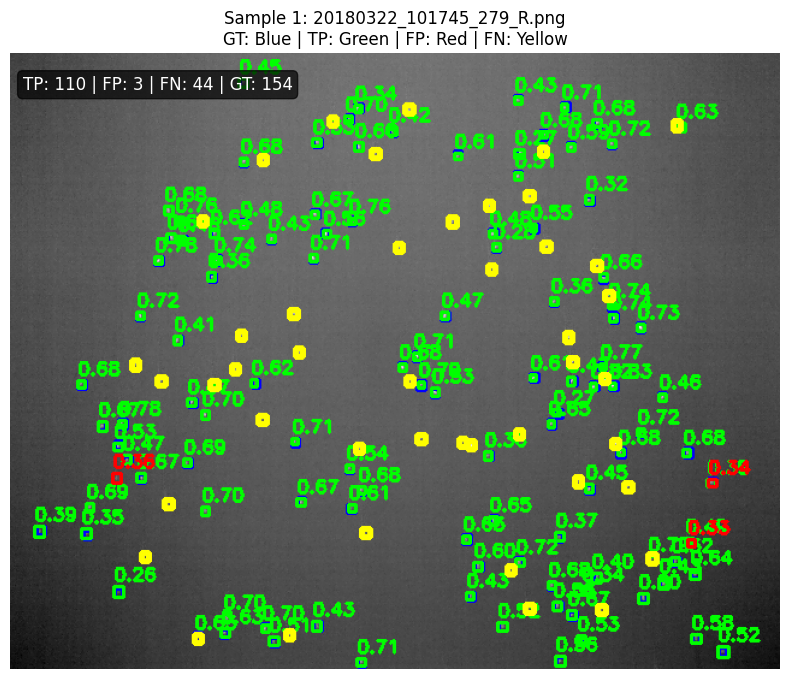


SAMPLE 2: 20180322_101743_173_R.png
Ground Truth Birds: 143
True Positives: 113 (correctly detected)
False Positives: 4 (false alarms)
False Negatives: 30 (missed birds)
Recall: 79.02% (detected 113 out of 143 birds)
Precision: 96.58% (113 correct out of 117 predictions)



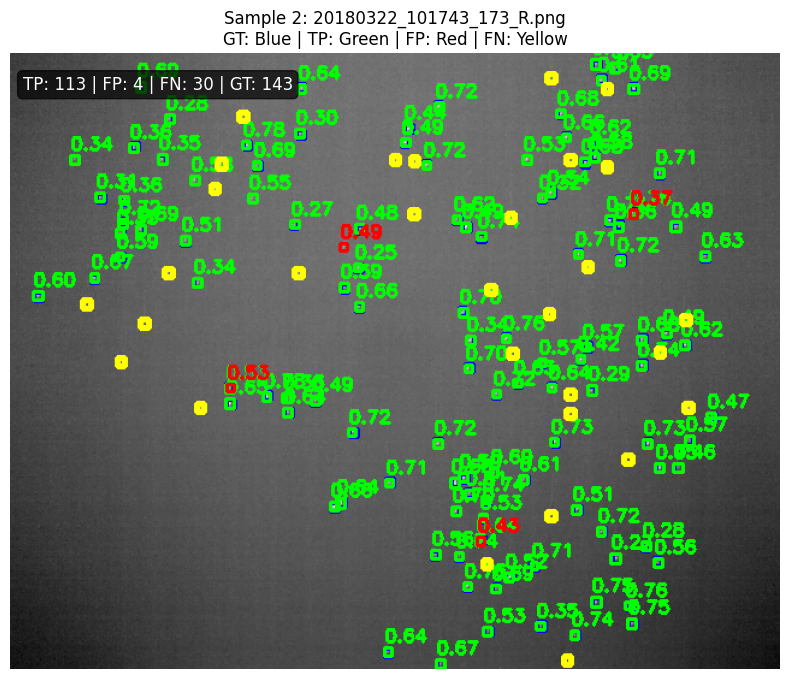


SAMPLE 3: 20180322_101817_573_R.png
Ground Truth Birds: 89
True Positives: 74 (correctly detected)
False Positives: 4 (false alarms)
False Negatives: 15 (missed birds)
Recall: 83.15% (detected 74 out of 89 birds)
Precision: 94.87% (74 correct out of 78 predictions)



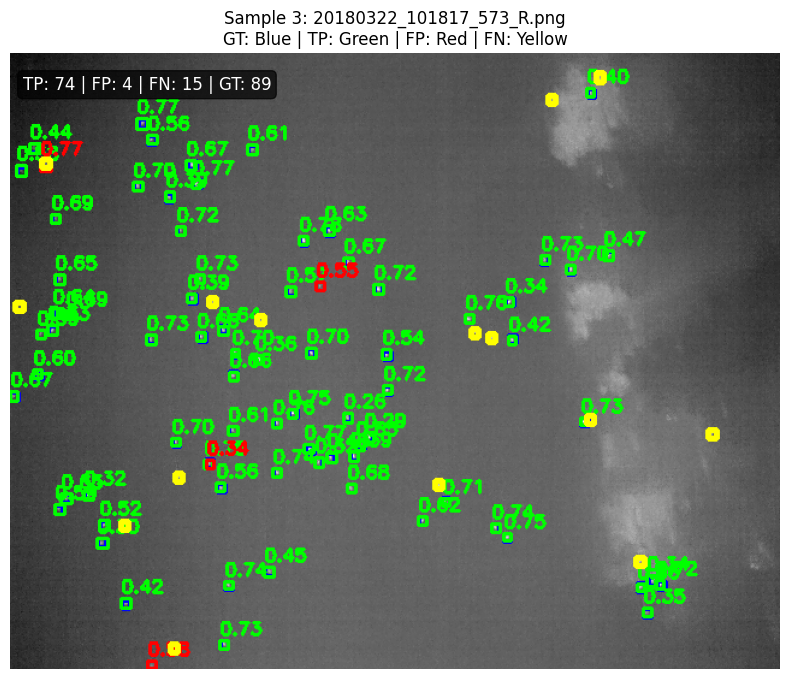


SAMPLE 4: 20180322_101612_281_R.png
Ground Truth Birds: 86
True Positives: 62 (correctly detected)
False Positives: 1 (false alarms)
False Negatives: 24 (missed birds)
Recall: 72.09% (detected 62 out of 86 birds)
Precision: 98.41% (62 correct out of 63 predictions)



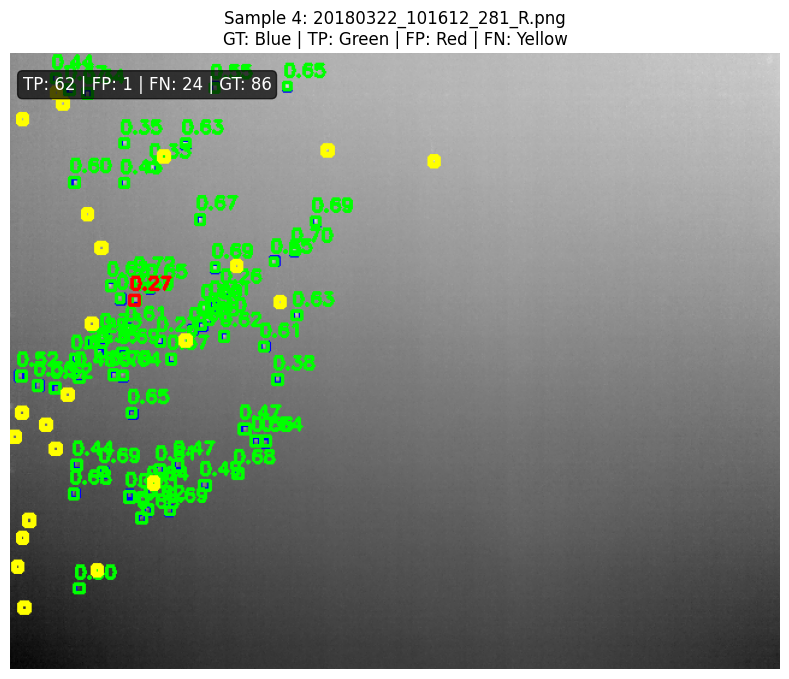


SAMPLE 5: 20180322_101611_280_R.png
Ground Truth Birds: 76
True Positives: 51 (correctly detected)
False Positives: 2 (false alarms)
False Negatives: 25 (missed birds)
Recall: 67.11% (detected 51 out of 76 birds)
Precision: 96.23% (51 correct out of 53 predictions)



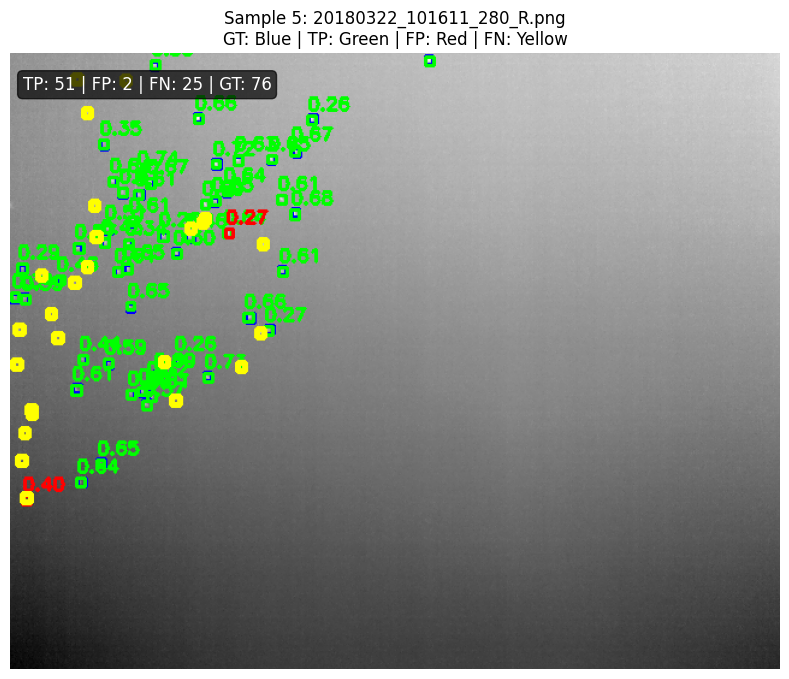


SUMMARY OF DETECTION TYPES
These samples show complex scenarios with many birds, demonstrating:
  ✓ True Positives (Green): Model successfully detected these birds
  ✗ False Negatives (Yellow): Model missed these birds (challenges: overlap, edges, low contrast)
  ⚠ False Positives (Red): Model incorrectly detected non-birds (challenges: reflections, noise)
  • Ground Truth (Blue): All actual bird locations marked by experts


In [ ]:
# Select images with the most ground truth labels
samples_with_most_gt = sorted(all_analyses, key=lambda x: x['total_gt'], reverse=True)[:5]

print("="*80)
print("DETAILED SAMPLES - IMAGES WITH MOST WATERFOWL")
print("="*80)
print("\nLegend:")
print("Blue boxes = Ground Truth (GT) - actual bird locations")
print("Green boxes = True Positives (TP) - correct detections")
print("Red boxes = False Positives (FP) - incorrect detections")
print("Yellow boxes = False Negatives (FN) - missed birds")
print("="*80)

for idx, analysis in enumerate(samples_with_most_gt):
    print(f"\n{'='*80}")
    print(f"SAMPLE {idx+1}: {analysis['image_path'].name}")
    print(f"{'='*80}")
    print(f"Ground Truth Birds: {analysis['total_gt']}")
    print(f"True Positives: {analysis['tp_count']} (correctly detected)")
    print(f"False Positives: {analysis['fp_count']} (false alarms)")
    print(f"False Negatives: {analysis['fn_count']} (missed birds)")
    
    # Calculate metrics for this image
    if analysis['total_gt'] > 0:
        recall = analysis['tp_count'] / analysis['total_gt']
        print(f"Recall: {recall:.2%} (detected {analysis['tp_count']} out of {analysis['total_gt']} birds)")
    
    if (analysis['tp_count'] + analysis['fp_count']) > 0:
        precision = analysis['tp_count'] / (analysis['tp_count'] + analysis['fp_count'])
        print(f"Precision: {precision:.2%} ({analysis['tp_count']} correct out of {analysis['tp_count'] + analysis['fp_count']} predictions)")
    
    print()
    
    # Visualize with all detection types clearly marked
    img = visualize_detection_analysis(analysis, f"Sample {idx+1}: {analysis['image_path'].name}")
    plt.savefig(RESULTS_DIR / f'detailed_sample_{idx+1}.png', dpi=600, bbox_inches='tight')
    plt.show()